# 3. Bouquet Flower Classification

## Objectives 
* Build or get a data set of image files of bouquet flowers. It must contain at least 10 categories of flowers and 25 images for each category.
* Generate the training data
    * Using Orange, generate the Image Embeddings por each dataset with Inception V3.
    * Save the Image Embeddings and use them in a Jupyter notebook.
* Try at least 2 features for each one pf the following classifiers:
    * Logistic Regression
    * Neural Networks
    * SVM
    * Random Forest
* Mesaure the performance of the models, get and analize the confusion matrix.

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [72]:
df = pd.read_csv('./dataset.csv')

In [73]:
#Get the categories dictionary
from json import load
with open('./data/cat_to_name.json') as f:
    dictionary = load(f)

## Data Preprocessing

In the following block, it shows all the information about the dataset. Explaining a little, the nfeature is the result of the image embedding algorithm, and category is the target. The others features are the metadata of the image.

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,427.0,2591.934426,1934.192456,0.000000,686.500000,2434.000000,4870.500000,5862.000000
n0,427.0,0.123907,0.135906,0.000000,0.035596,0.079397,0.164688,0.865708
n1,427.0,0.296530,0.357501,0.000000,0.048361,0.140451,0.414406,1.968339
n2,427.0,0.706586,0.523713,0.009525,0.334935,0.596198,0.980846,3.007994
n3,427.0,0.423048,0.328542,0.000691,0.170172,0.346462,0.620304,1.787014
...,...,...,...,...,...,...,...,...
n2047,427.0,0.392623,0.331344,0.000000,0.129059,0.312468,0.577325,1.635965
category,427.0,5.688525,2.766998,1.000000,3.000000,6.000000,8.000000,10.000000
size,427.0,41176.189696,12408.781580,15537.000000,33126.500000,39450.000000,47660.000000,100863.000000
width,427.0,594.259953,95.112660,500.000000,500.000000,587.000000,667.000000,845.000000


In [75]:
#Change the keys, from string to int
dictionary = { int(k): v for k, v in dictionary.items() }

In [76]:
#To know which flowers we have
print('Categories:')
keys = df.category.unique()
for k in keys:
    print(f'{k}: {dictionary[k]}')

Categories:
1: pink primrose
10: globe thistle
2: hard-leaved pocket orchid
3: canterbury bells
4: sweet pea
5: english marigold
6: tiger lily
7: moon orchid
8: bird of paradise
9: monkshood


In [77]:
#Separate our possible features from the target
X, y = df.drop(['category', 'size', 'width', 'height', 'image name', 'image', 'id'], axis=1), df['category']

In [78]:
#For selecting the best features, will use the next utilities from sklearn
from sklearn.feature_selection import SelectKBest, chi2
best_features = SelectKBest(chi2, k=10).fit(X, y)

In [79]:
#I will be creating a new df with all the features and correlations with the target
n_features = 2048
df_scores = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X.columns)

#concat
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Specs', 'Score']

features_to_use = list(feature_scores.nlargest(n_features, 'Score').Specs)
#print(feature_scores.nlargest(n_features, 'Score'))

In [80]:
#To know how correleated are the features with the categories
"""%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(df[features_to_use + ['category']].corr(), annot=True)"""

"%matplotlib inline\nsns.set(rc={'figure.figsize':(20,10)})\nsns.heatmap(df[features_to_use + ['category']].corr(), annot=True)"

As we can see, there is not too much correlationship between category and all the features, been bellow the 0.5 of correlation. However, there is a set of features strong correlated, so, it can be useful for the models.

In [81]:
#I'll separate the X from the selected features
x = X[features_to_use]

In [82]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [83]:
#For logistic regression, it is necessary to normalize 
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train, y_train)
x_test_scaled = standard_scaler.fit_transform(x_test, y_test)

## Model Creation

In [84]:
"""Logistic Regression"""
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100)

In [85]:
"""Neural networks"""
from sklearn.neural_network import MLPClassifier
neural_network = MLPClassifier(max_iter=500, solver='lbfgs')

In [86]:
"""SVM"""
from sklearn.svm import SVC
svm = SVC()

In [87]:
"""Random Forest"""
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

## Adjust Model with Historic Data

In [88]:
"""Logistic Regression"""
log_reg.fit(x_train_scaled, y_train)

d:\iteso\machine-learning\workspace\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
"""Neural network"""
neural_network.fit(x_train, y_train)

MLPClassifier(max_iter=500, solver='lbfgs')

In [90]:
"""SVM"""
svm.fit(x_train, y_train)

SVC()

In [91]:
"""Random Forest"""
random_forest.fit(x_train, y_train)

RandomForestClassifier()

# Prediction for New Data

In [92]:
log_reg_pred = log_reg.predict(x_test_scaled)
neural_network_pred = neural_network.predict(x_test)
svm_pred = svm.predict(x_test)
random_forest_pred = random_forest.predict(x_test)

In [93]:
def decode_classification(input, dictionary) -> list:
    """Returns a list mapping the code of the classification to the corresponding etiquettes.

    Args:
        input (list[int]): The list of the codes of the dictionary.
        dictionary (dict[int: string]): The dictionary of etiquettes.

    Returns:
        list: A list of the categories.
    """
    return [dictionary[i] for i in input]

In [94]:
log_reg_pred = decode_classification(log_reg_pred, dictionary)
neural_network_pred = decode_classification(neural_network_pred, dictionary)
svm_pred = decode_classification(svm_pred, dictionary)
random_forest_pred = decode_classification(random_forest_pred, dictionary)


In [95]:
y_test = decode_classification(y_test, dictionary)

## Visualization of the results

In [96]:
from sklearn.metrics import confusion_matrix

In [97]:
from sklearn.model_selection import cross_val_score

In [98]:
scores = [ 
    cross_val_score(log_reg, x_test_scaled, y_test, cv=3, scoring='accuracy').mean(), 
    cross_val_score(neural_network, x_test, y_test, cv=3, scoring='accuracy').mean(), 
    cross_val_score(svm, x_test, y_test, cv=3, scoring='accuracy').mean(), 
    cross_val_score(random_forest, x_test, y_test, cv=3, scoring='accuracy').mean(), 
]

print(scores)

[0.9076354679802955, 0.8838259441707718, 0.7799671592775042, 0.8025451559934318]


In [99]:
confusion_matrix_list = [
    (confusion_matrix(y_test, log_reg_pred), 'Logistic Regression'),
    (confusion_matrix(y_test, neural_network_pred), 'Neural Network'),
    (confusion_matrix(y_test, svm_pred), 'SVM'),
    (confusion_matrix(y_test, random_forest_pred), 'Random Forest'),
]

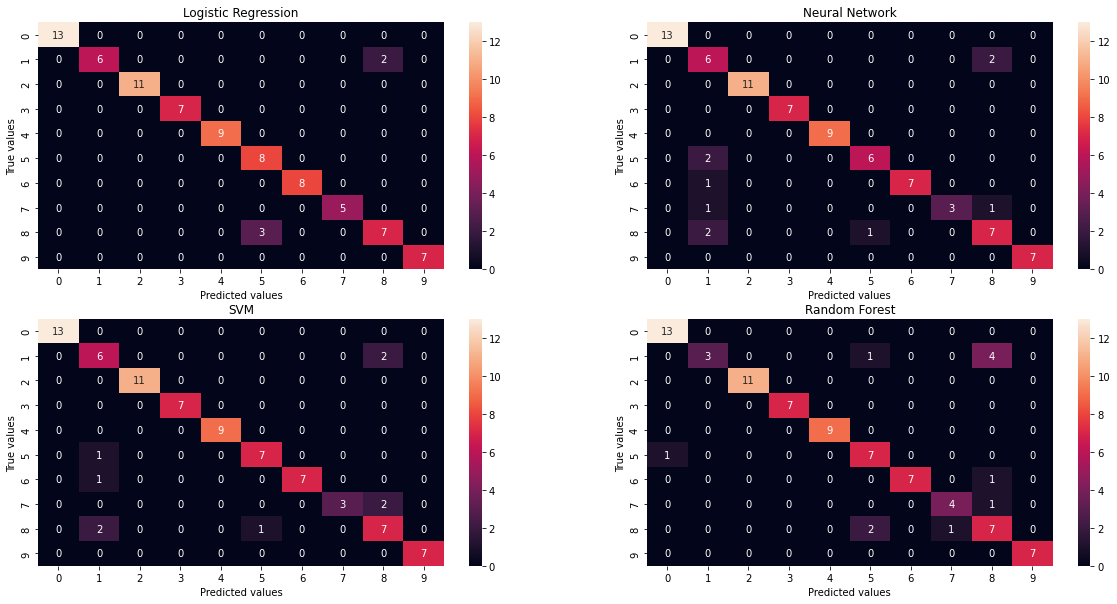

In [100]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(20,10))
for i, ax in enumerate(axs.flat):
    cf, name = confusion_matrix_list[i]
    sns.heatmap(cf, fmt='d', annot=True, ax=ax)
    ax.set(ylabel='True values')
    ax.set(xlabel='Predicted values')
    ax.set(title=f'{name}')

### Which type of flower gets the best results?
The type of flower which gets the best results was bird of paradise. This is because is the most common flower in the data set.

### Which flower was the most difficult to classify?
The type of flower that was the most difficult to classify was canterbury bells.

### Which model gets the best results?
The model with the best results was the Logistic Regression model.

### How do you think we can improve the obtained results?
We can improve the obtained results using features that are more correlationed features.

### how differents the results are between the training set and the test set?
The training set gets better results than the test set.